In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

matplotlib.rcParams['figure.figsize'] = [12, 7]

In [ ]:
def inquire_nongauss_table(table_name, input_cld, input_innov):

    # first read table in:
    read_cloud_bin_next = False
    read_bias_next      = False
    read_stdev_next     = False
    ct = 0
    with open(table_name, 'r') as file:
        # Read the file line by line into a list
        lines = file.readlines()
    
        # Process each line
        for line in lines:
            # basic parameters
            if line[0:9] == 'max_range':
                max_range = float(line[17:])
            elif line[0:2] == 'dx':
                dx        = float(line[17:])
            elif line[0:9] == 'bdy_slope':
                bdy_slope = float(line[17:])
            elif line[0:13] == 'num_cloud_cat':
                num_cloud_cat = float(line[17:])
                stdev = np.zeros((int(num_cloud_cat), 2*int(max_range/dx)+1))
        
            # cloud bin
            if line[0:11] == 'cloud_bin::':
                read_cloud_bin_next = True
                continue
            
            if read_cloud_bin_next:
                cloud_bin = np.array(line.split(), dtype=np.float64)
                read_cloud_bin_next = False
        
            if line[0:6] == 'bias::':
                read_bias_next = True
                continue
            
            if read_bias_next:
                bias = np.array(line.split(), dtype=np.float64)
                read_bias_next = False
            
            if line[0:7] == 'stdev::':
                read_stdev_next = True
                continue
            
            if read_stdev_next:
                stdev[ct,:] = np.array(line.split(), dtype=np.float64)
                ct+=1
                if ct>=num_cloud_cat:
                    read_stdev_next = False
                    
    
    # then interpolate the table to get the standard deviation:
    cc = int(min(num_cloud_cat-1, np.where(input_cld - cloud_bin >= 0)[0][-1]))

    # move the innovation to 'mode relative innovation':
    input_innov = input_innov + bias[cc]
    
    # interpolate to get the stdev:
    if input_innov <= -max_range:
        output_stdev = stdev[cc,0] + bdy_slope*(-max_range - input_innov)
    elif input_innov >= max_range:
        output_stdev = stdev[cc,-1] + bdy_slope*(input_innov - max_range)
    else:
        output_stdev = np.interp(input_innov, np.arange(-max_range, max_range+dx, dx), stdev[cc,:] )

    return output_stdev

In [110]:
# compare the standard deviation map for different observation error models:
instrument = 'amsua'
channel    = 'ch15'
predictor  = 'obs_cld'

if instrument == 'amsua':
    if channel in ('ch1','ch3'):
        omf_max = 30
        omf_min = -30
        domf    = 1
        cloud_test = np.array([0.02, 0.04, 0.08, 0.12, 0.18, 0.22, 0.28, 0.32, 0.40])
        omf_test   = np.arange(omf_min, omf_max + domf, domf)

    elif channel in ('ch4'):
        omf_max = 10
        omf_min = -10
        domf    = 0.2
        cloud_test = np.array([0.02, 0.04, 0.08, 0.12, 0.18, 0.22, 0.28, 0.32, 0.40])
        omf_test   = np.arange(omf_min, omf_max + domf, domf)
        
    elif channel in ('ch2'):
        omf_max = 40
        omf_min = -40
        domf    = 1
        cloud_test = np.array([0.02, 0.04, 0.08, 0.12, 0.18, 0.22, 0.28, 0.32, 0.40])
        omf_test   = np.arange(omf_min, omf_max + domf, domf)
        
    elif channel in ('ch5'):
        omf_max = 5
        omf_min = -5
        domf    = 0.05
        cloud_test = np.array([0.02, 0.04, 0.08, 0.12, 0.18, 0.22, 0.28, 0.32, 0.38, 0.60])
        omf_test   = np.arange(omf_min, omf_max + domf, domf)
        
    elif channel in ('ch15'):
        omf_max = 30
        omf_min = -30
        domf    = 1
        cloud_test = np.array([0.02, 0.04, 0.08, 0.12, 0.18, 0.22, 0.40])
        omf_test   = np.arange(omf_min, omf_max + domf, domf)
            
        
stdev_sym_cld      = np.zeros((len(cloud_test), len(omf_test)))
stdev_no_predictor = np.zeros(len(omf_test))

for ii in range(len(cloud_test)):
    for jj in range(len(omf_test)):
        stdev_sym_cld[ii,jj] = inquire_nongauss_table(f'non_Gaussian_{instrument}_{channel}_OmF_{predictor}_qc_00_03.txt', cloud_test[ii], omf_test[jj])
        #stdev_sym_cld[ii,jj] = inquire_nongauss_table(f'non_Gaussian_{instrument}_{channel}_OmF_obs_cld_qc_00_03.txt', cloud_test[ii], omf_test[jj])
        
for jj in range(len(omf_test)):
    stdev_no_predictor[jj] = inquire_nongauss_table(f'non_Gaussian_{instrument}_{channel}_OmF_no_predictor_qc_00_03.txt', 0.5, omf_test[jj])
        

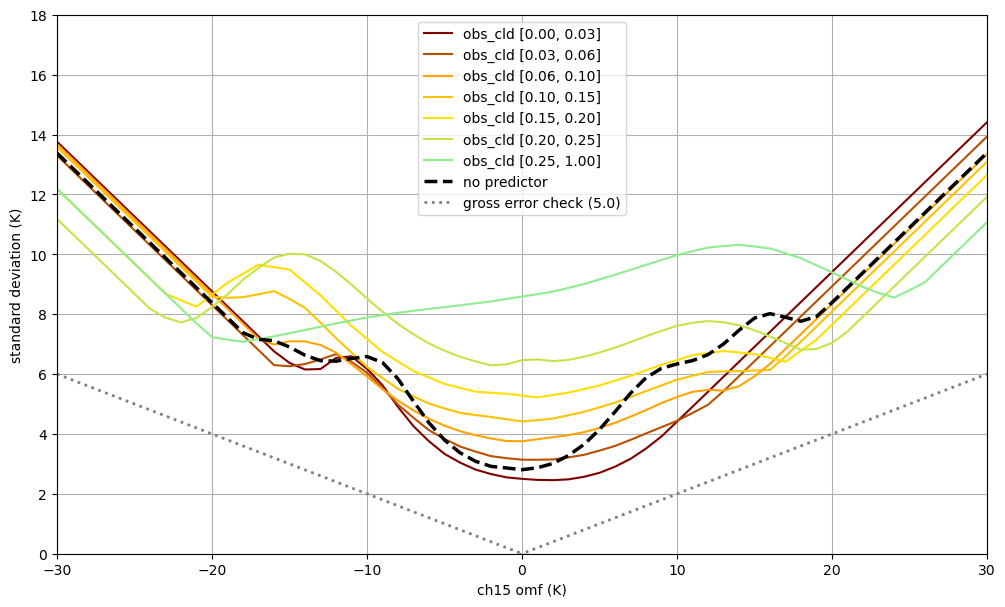

In [111]:

if channel in ('ch1','ch2','ch3','ch4'):
    plt.plot(omf_test, stdev_sym_cld[0,:], color=(128/256,   0/256,   0/256), label=f'{predictor} [0.00, 0.03]')
    plt.plot(omf_test, stdev_sym_cld[1,:], color=(185/256,  80/256,   0/256), label=f'{predictor} [0.03, 0.06]')
    plt.plot(omf_test, stdev_sym_cld[2,:], color=(256/256, 165/256,   0/256), label=f'{predictor} [0.06, 0.10]')
    plt.plot(omf_test, stdev_sym_cld[3,:], color=(256/256, 195/256,   0/256), label=f'{predictor} [0.10, 0.15]')
    plt.plot(omf_test, stdev_sym_cld[4,:], color=(256/256, 223/256,   0/256), label=f'{predictor} [0.15, 0.20]')
    plt.plot(omf_test, stdev_sym_cld[5,:], color=(195/256, 230/256,  72/256), label=f'{predictor} [0.20, 0.25]')
    plt.plot(omf_test, stdev_sym_cld[6,:], color=(144/256, 238/256, 144/256), label=f'{predictor} [0.25, 0.30]')
    plt.plot(omf_test, stdev_sym_cld[7,:], color=( 72/256, 215/256, 195/256), label=f'{predictor} [0.30, 0.35]')
    plt.plot(omf_test, stdev_sym_cld[8,:], color=(  0/256, 191/256, 256/256), label=f'{predictor} [0.35, 1.00]')

elif channel in ('ch5'):
    plt.plot(omf_test, stdev_sym_cld[0,:], color=(128/256,   0/256,   0/256), label=f'{predictor} [0.00, 0.03]')
    plt.plot(omf_test, stdev_sym_cld[1,:], color=(185/256,  80/256,   0/256), label=f'{predictor} [0.03, 0.06]')
    plt.plot(omf_test, stdev_sym_cld[2,:], color=(256/256, 165/256,   0/256), label=f'{predictor} [0.06, 0.10]')
    plt.plot(omf_test, stdev_sym_cld[3,:], color=(256/256, 195/256,   0/256), label=f'{predictor} [0.10, 0.15]')
    plt.plot(omf_test, stdev_sym_cld[4,:], color=(256/256, 223/256,   0/256), label=f'{predictor} [0.15, 0.20]')
    plt.plot(omf_test, stdev_sym_cld[5,:], color=(195/256, 230/256,  72/256), label=f'{predictor} [0.20, 0.25]')
    plt.plot(omf_test, stdev_sym_cld[6,:], color=(144/256, 238/256, 144/256), label=f'{predictor} [0.25, 0.30]')
    plt.plot(omf_test, stdev_sym_cld[7,:], color=( 90/256, 222/256, 182/256), label=f'{predictor} [0.30, 0.35]')
    plt.plot(omf_test, stdev_sym_cld[8,:], color=( 45/256, 205/256, 218/256), label=f'{predictor} [0.35, 0.40]')
    plt.plot(omf_test, stdev_sym_cld[9,:], color=(  0/256, 191/256, 256/256), label=f'{predictor} [0.40, 1.00]')

elif channel in ('ch15'):
    plt.plot(omf_test, stdev_sym_cld[0,:], color=(128/256,   0/256,   0/256), label=f'{predictor} [0.00, 0.03]')
    plt.plot(omf_test, stdev_sym_cld[1,:], color=(185/256,  80/256,   0/256), label=f'{predictor} [0.03, 0.06]')
    plt.plot(omf_test, stdev_sym_cld[2,:], color=(256/256, 165/256,   0/256), label=f'{predictor} [0.06, 0.10]')
    plt.plot(omf_test, stdev_sym_cld[3,:], color=(256/256, 195/256,   0/256), label=f'{predictor} [0.10, 0.15]')
    plt.plot(omf_test, stdev_sym_cld[4,:], color=(256/256, 223/256,   0/256), label=f'{predictor} [0.15, 0.20]')
    plt.plot(omf_test, stdev_sym_cld[5,:], color=(195/256, 230/256,  72/256), label=f'{predictor} [0.20, 0.25]')
    plt.plot(omf_test, stdev_sym_cld[6,:], color=(144/256, 238/256, 144/256), label=f'{predictor} [0.25, 1.00]')

plt.plot(omf_test, stdev_no_predictor, linestyle='--', linewidth=2.5, color='black', label='no predictor')

# the gross error check criterion:
gross_error_fact = 5.0
plt.plot(omf_test,  omf_test/gross_error_fact, linestyle=':', linewidth=2.0, color='gray',label=f'gross error check ({gross_error_fact})')
plt.plot(omf_test, -omf_test/gross_error_fact, linestyle=':', linewidth=2.0, color='gray')

plt.xlabel(f'{channel} omf (K)')
plt.ylabel('standard deviation (K)')
if channel in ('ch1','ch3','ch15'):
    plt.xlim([-30,30])
    plt.ylim([  0,18])
elif channel in ('ch2'):
    plt.xlim([-40,40])
    plt.ylim([  0,25])
elif channel in ('ch4'):
    plt.xlim([-6,6])
    plt.ylim([ 0,4])
elif channel in ('ch5'):
    plt.xlim([-2,2])
    plt.ylim([0,1.2])

plt.grid(True)
plt.legend()
plt.savefig(f'stdev_map_{instrument}_{channel}_{predictor}_and_no_predictor.png')
plt.show()
